## Sequence to Sequence: Encoder & Decoder Architecture

In [43]:
import copy
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, \
TensorDataset
from data_generation.square_sequence import generate_sequences
from stepbystep.v4 import StepByStep

In [44]:
#Creating data points (of squares) and their direction
points, directions=generate_sequences(n=128, seed=13)

## Encoder
" The encoder's goal is to generate a representation of the $\textbf{source sequence}$, that is, to encode it

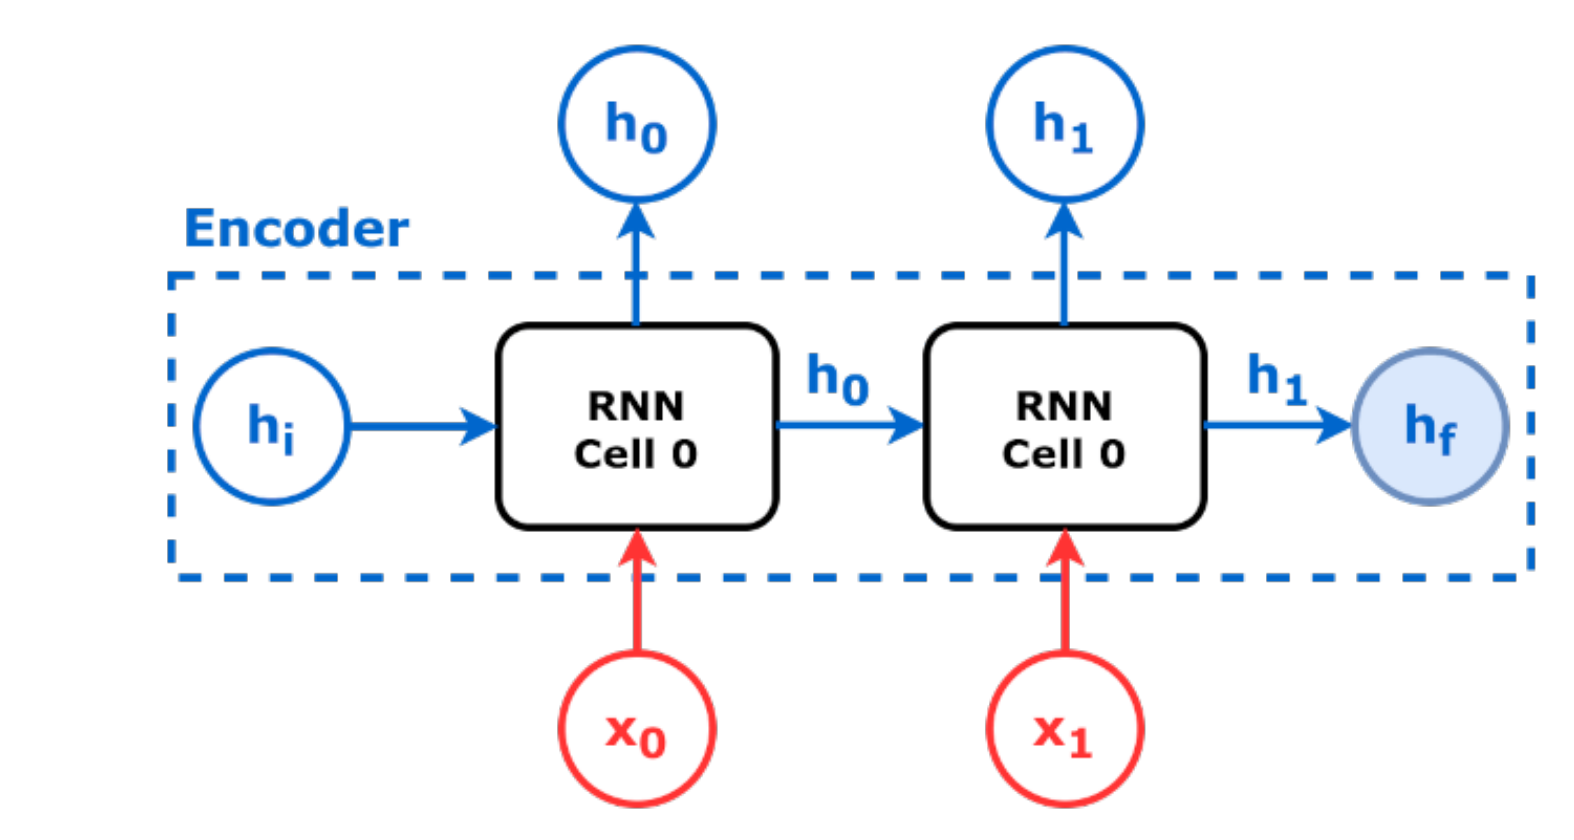

In [45]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.n_features=n_features
        self.hidden=None
        self.basic_rnn=nn.GRU(
        self.n_features,
        self.hidden_dim,
        batch_first=True)
    
    def forward(self, X):
        rnn_out, self.hidden=self.basic_rnn(X)
        
        return rnn_out
        

In [46]:
#ejemplo de un cuadrado perfecto
full_seq=(torch.tensor([[-1,-1],[-1,1],[1,1],[1,-1]])).float().view(1,4,2)
source_seq=full_seq[:,:2,:]
target_seq=full_seq[:,2:,:]

In [47]:
source_seq, source_seq.size()

(tensor([[[-1., -1.],
          [-1.,  1.]]]),
 torch.Size([1, 2, 2]))

In [48]:
torch.manual_seed(21)
encoder=Encoder(n_features=2, hidden_dim=2)
hidden_seq=encoder(source_seq) #output N, L F
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [49]:
#The last hidden state is the one that encode in a better way the whole sequence
final_state=hidden_seq[:,-1:,:]
final_state

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward>)

## Decoder
The decoder's goal is to generate the target sequence from an initial representation, that is, to decode it

In order to decode the hidden state of into a sequence, the decoder needs a recurent layer as well
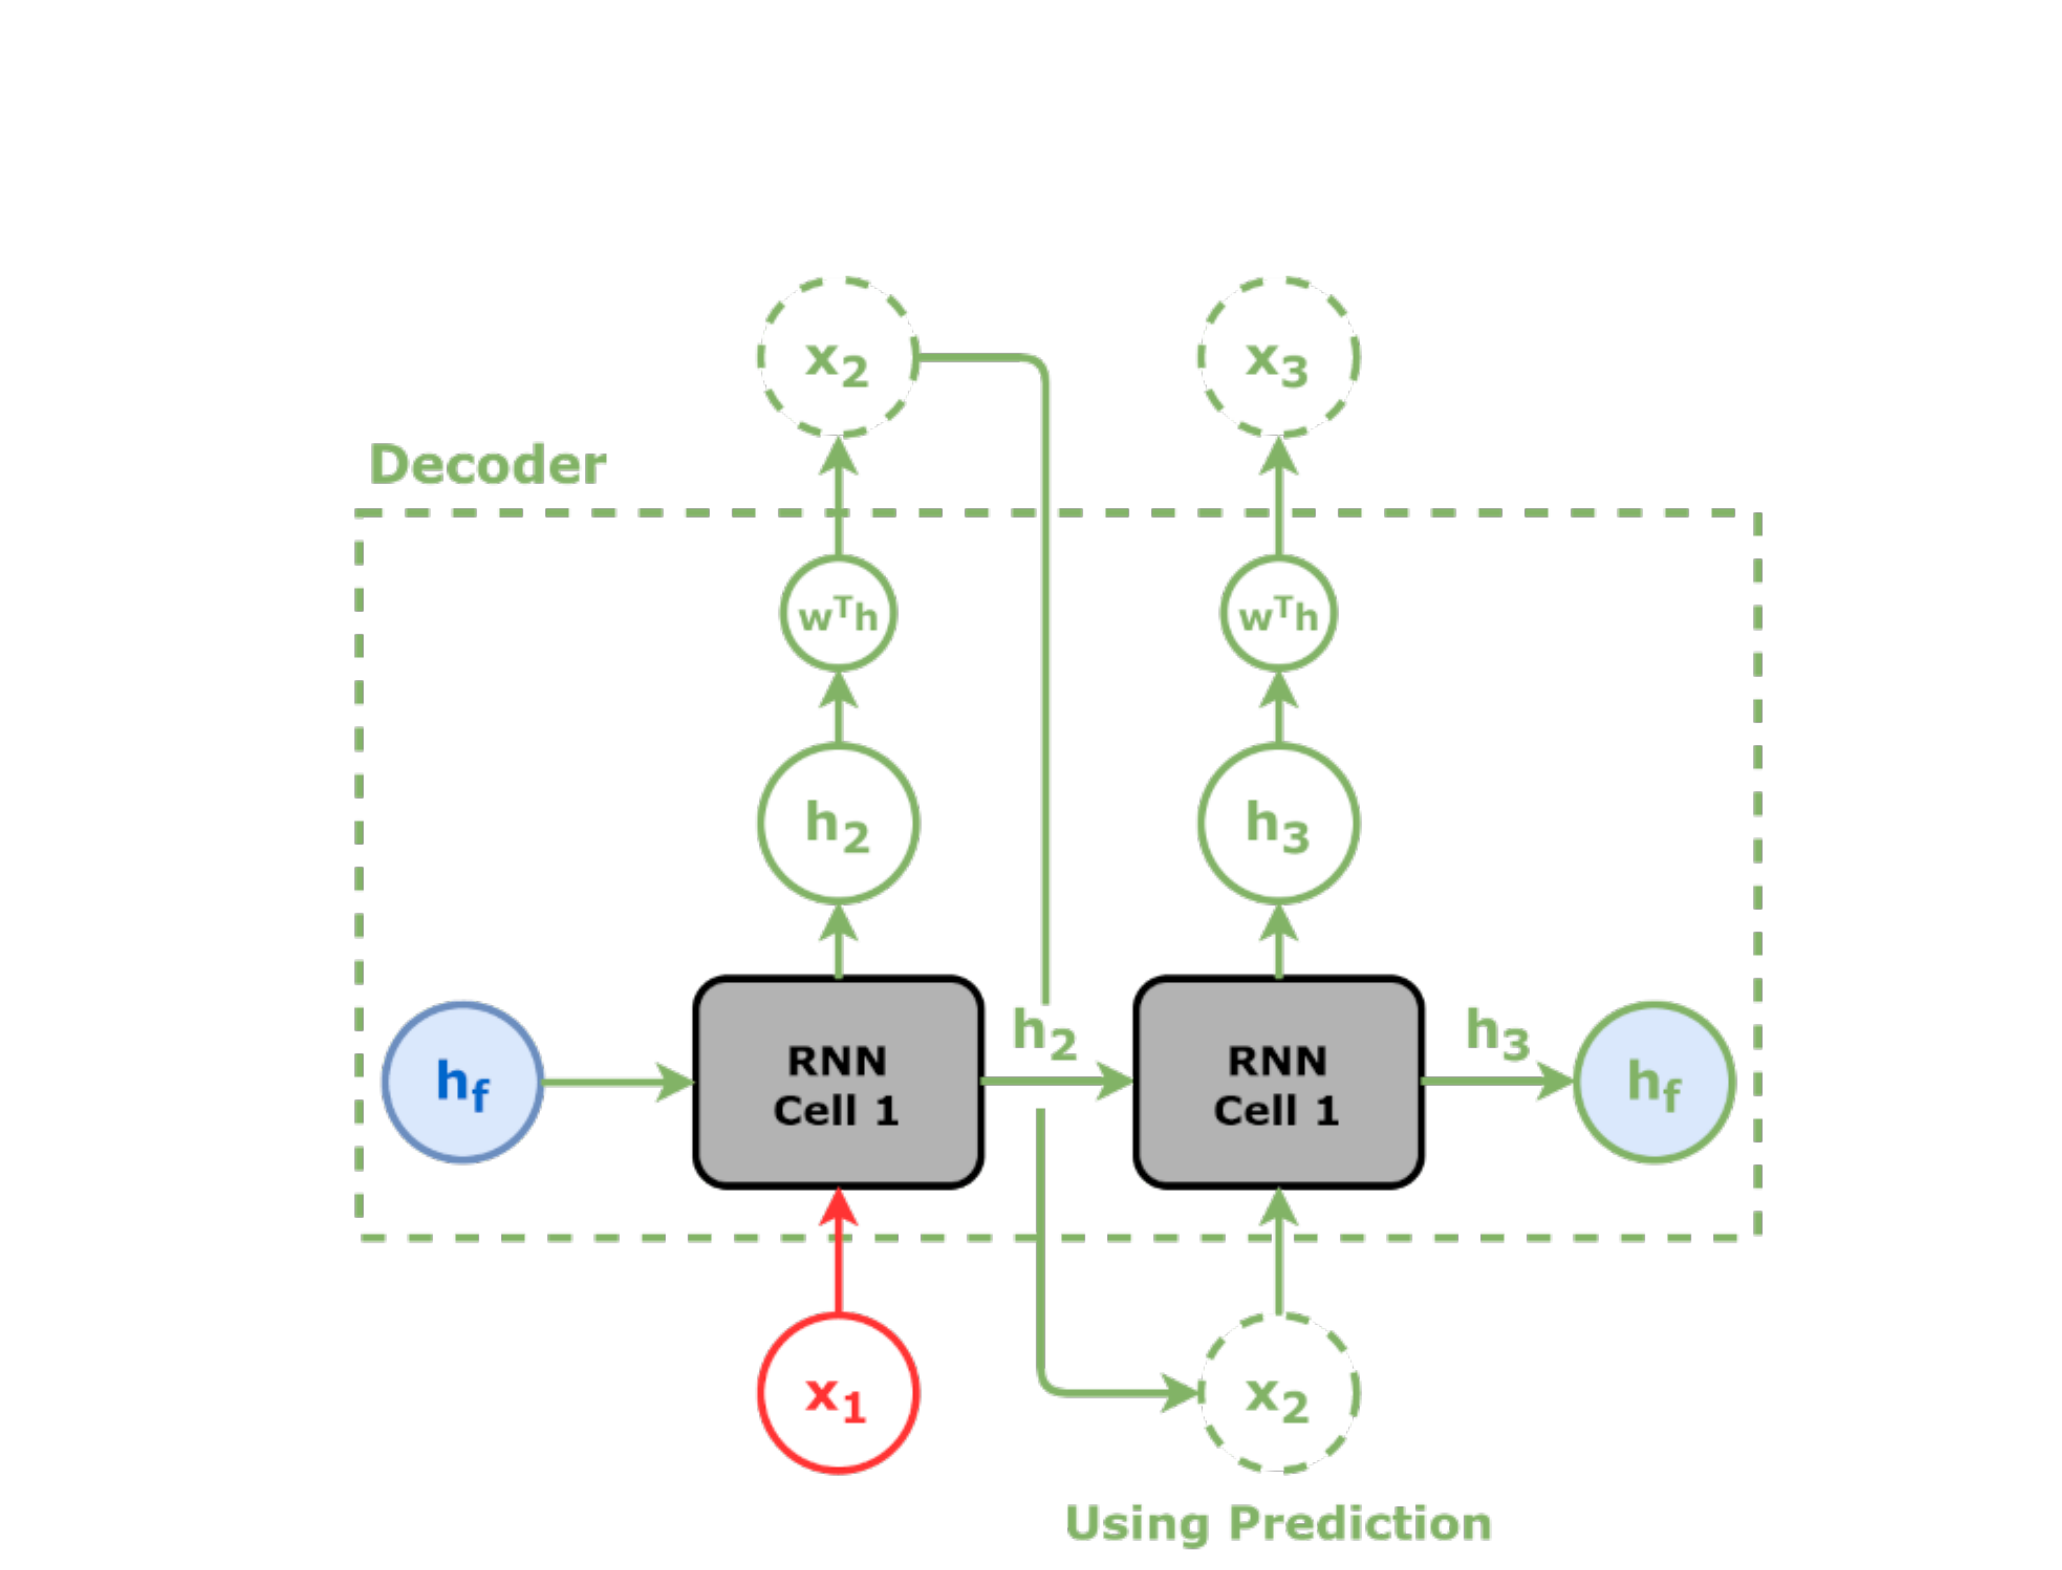

In [50]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.n_features=n_features
        self.hidden_dim=hidden_dim
        self.basic_rnn=nn.GRU(self.n_features, 
                             self.hidden_dim)
        self.regression=nn.Linear(self.hidden_dim, n_features)
    
    def init_hidden(self, hidden_seq):
        #we only need the final state
        hidden_final=hidden_seq[:,-1:,:] #N,1,H
        #but it is needed to make this sequence-first
        self.hidden=hidden_final.permute(1,0,2) #1,N,H
        
    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden=self.basic_rnn(X, self.hidden)
        
        last_output=batch_first_output[:,-1:,:]
        out=self.regression(last_output)
        
        #N,1,F
        return out.view(-1,1,self.n_features)

In [51]:
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [52]:
torch.manual_seed(21)
decoder=Decoder(n_features=2, hidden_dim=2)

#initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
#initial data point is the last element of source sequence
inputs=source_seq[:,-1:,:]

target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs) #predicts coordinates
    print(f"Outputs: {out}\n")
    inputs=out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Outputs: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Outputs: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



## Teacher Forcing

In the last cell, the decoder was feed with the output prediction of itself; then, an untrained model will make really mad predictions, and this predictions will still be used as inputs for subsequent steps.

### Teacher forcing
But we can use actual target instead

In [53]:
#as before, initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
#initial datapoint is the last element of source sequence
inputs=source_seq[:,-1:]

target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs) #predicts coordinates
    print(f"Outputs: {out}\n")
    inputs=target_seq[:,i:i+1]
    

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
Outputs: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
Outputs: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward>)



In terms of training time this is amazing, but at testing time when the target sequence is unkown this will not help us.

That's why it is customary to alternate over teacher forcing and use as input decoder's own predictions:

In [54]:
decoder.init_hidden(hidden_seq)
inputs=source_seq[:,-1:,:]

teacher_forcing_prob=.5
target_len=2
for i in range(target_len):
    print(f"Hidden: {decoder.hidden}")
    out=decoder(inputs)
    print(f"outout: {out}\n")
    #if teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        #takes tehe actual element
        inputs=target_seq[:,i:i+1,:]
    else:
        inputs=out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward>)
outout: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward>)
outout: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward>)



# Encoder-Decoder (with recurrent units)

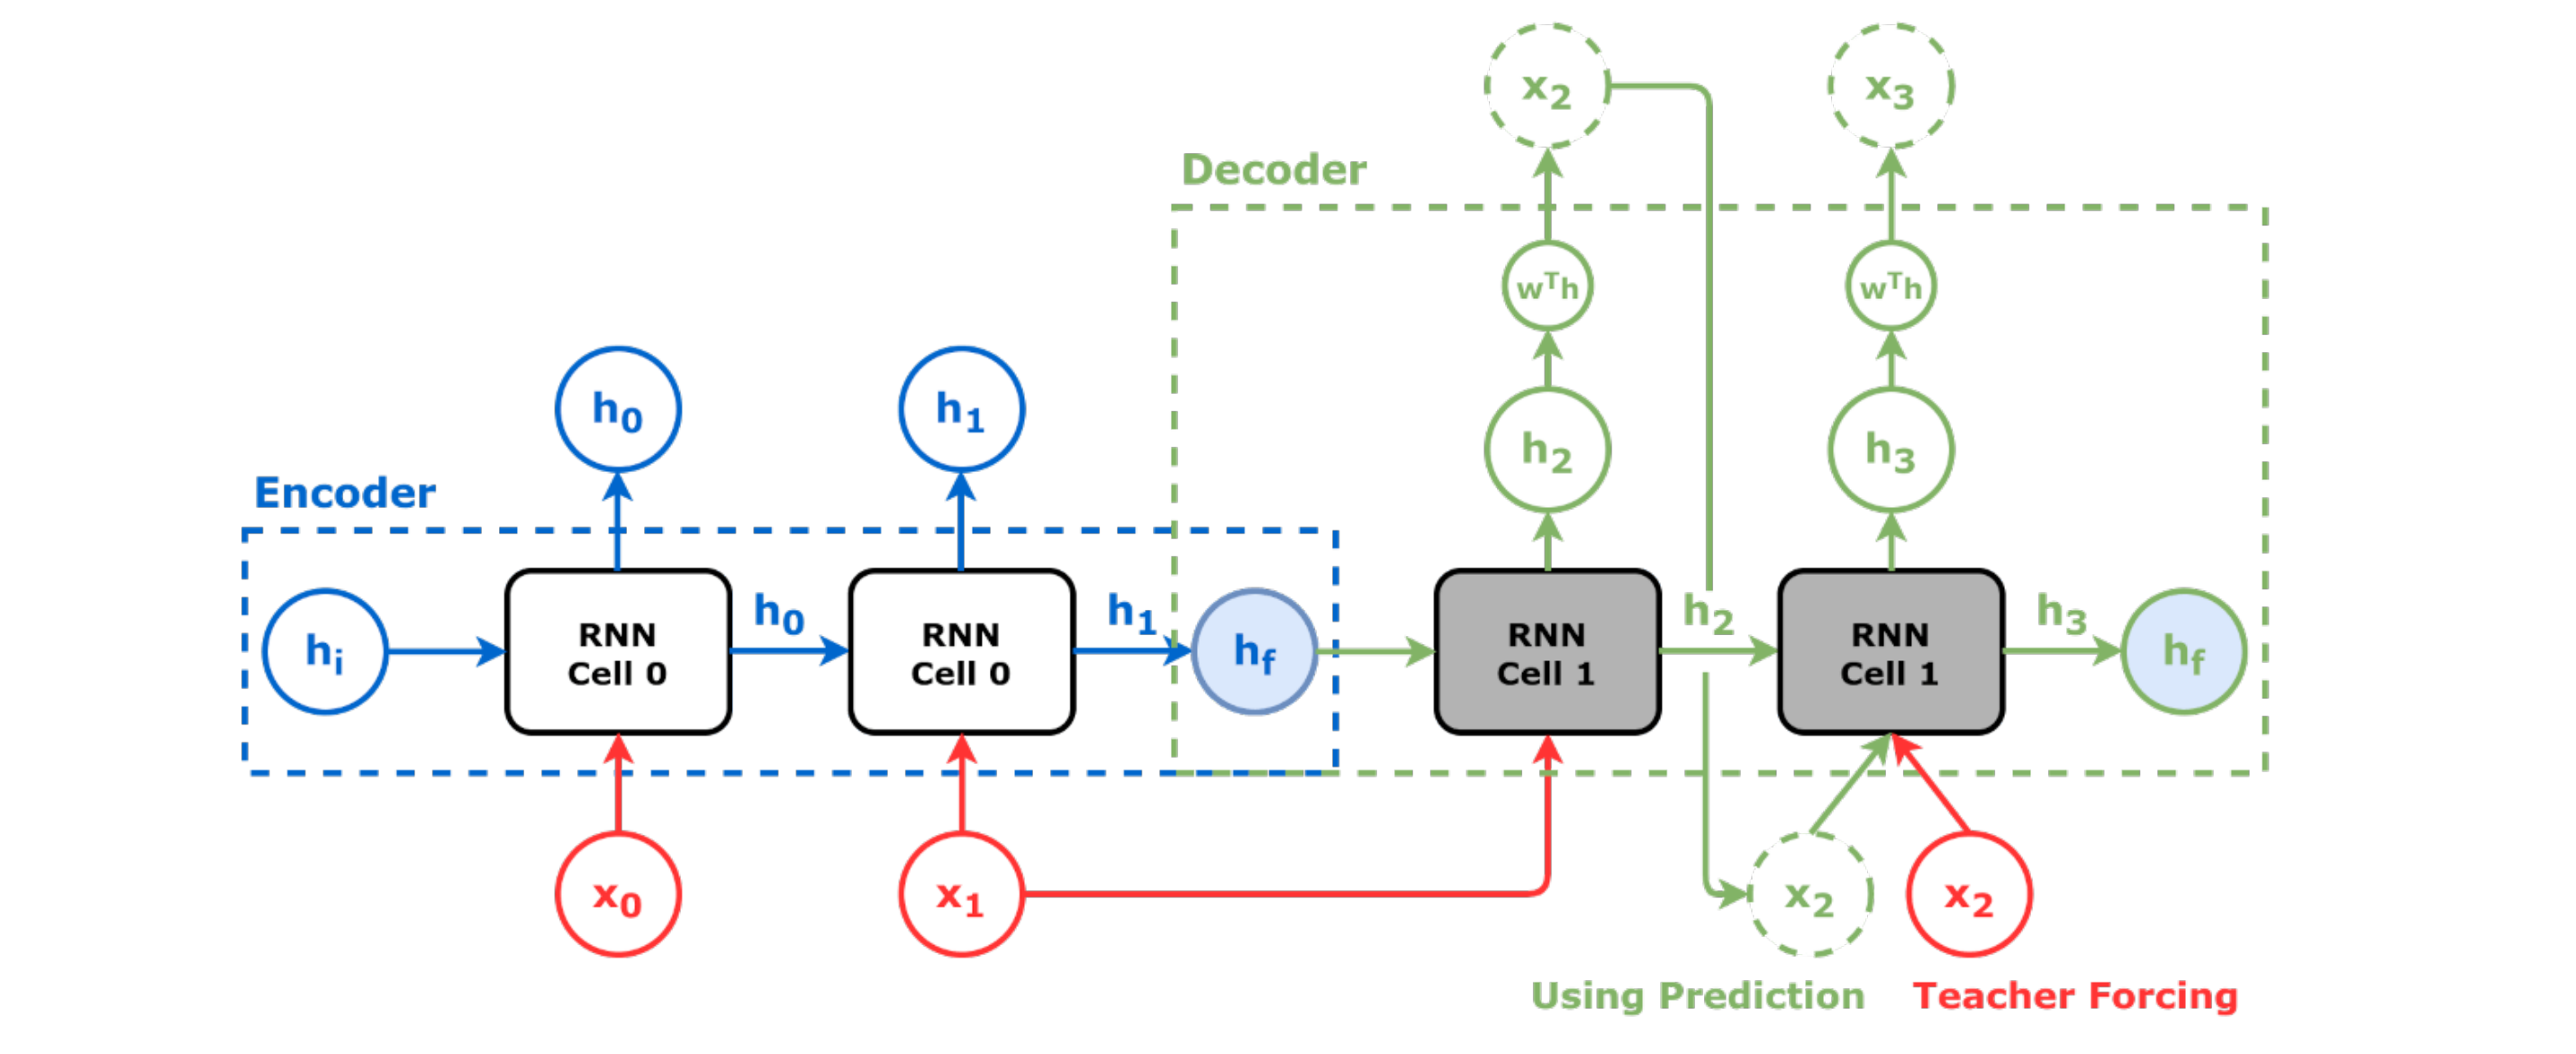

In [55]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len,
                teacher_forcing_prob=.5):
        super().__init__()
        self.encoder=encoder
        self.decoder=decoder
        self.input_len=input_len
        self.target_len=target_len
        self.teacher_forcing_prob=teacher_forcing_prob
        self.outputs=None
        
    def init_outputs(self,batch_size):
        device=next(self.parameters()).device
        #N,L(target), F
        self.outputs=torch.zeros(batch_size, 
                                self.target_len,
                                self.encoder.n_features).to(device)
    def store_output(self, i, out):
        self.outputs[:,i:i+1,:]=out
    
    def forward(self, X):
        #splits the data in source and target sequences
        #the target se will be emptu in testing mode
        #N,L,F
        source_seq=X[:, :self.input_len, :]
        target_seq=X[:, self.input_len:, :]
        #zeros matrix is created in the line below
        self.init_outputs(X.shape[0])
        
        #Encoder expected, N,L,F
        hidden_seq=self.encoder(source_seq)
        self.decoder.init_hidden(hidden_seq)
        
        #the last input of the encoder is also
        #the fist input of the decoder
        dec_inputs=source_seq[:, -1: ,:]
        
        for i in range(self.target_len):
            #Output of decoder is N,1,F
            out=self.decoder(dec_inputs)
            self.store_output(i, out)
            
            prob=self.teacher_forcing_prob
            #In eval/test the target sequence is 
            #Unknown, so we cannot use teacher forcing
            if not self.training:
                prob=0
            #if it is training time
            if torch.rand(1)<= prob:
                #takes the actua element
                dec_inputs=target_seq[:,i:i+1, :]
            else:
                dec_inputs=out
                
            return self.outputs
        
        

In [56]:
#Create an instance of the above model
encdec=EncoderDecoder(encoder, decoder,
                     input_len=2, target_len=2,
                     teacher_forcing_prob=.5)

In [57]:
# In training mode, the model expects the full sequence, so it can randomly use teacher
#forcing
encdec.train()
print(encdec(full_seq))
# while in eval/test mode, it only need the source sequence as input
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.0000,  0.0000]]], grad_fn=<CopySlices>)


tensor([[[-0.2339,  0.4702],
         [ 0.0000,  0.0000]]], grad_fn=<CopySlices>)

In [58]:
# Data preparation (TRAIN)
points, directions=generate_sequences()
full_train=torch.as_tensor(points).float()
target_train=full_train[:,2:,:]

In [59]:
#for test set, we only need the source sequence as features (X) and the target 
#sequence as labels (y)
test_points, test_directions=generate_sequences(seed=19)
full_test=torch.as_tensor(points).float()
source_test=full_test[:,:2,:]
target_test=full_test[:,2:,:]


In [60]:
#create TensorDatasets
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

In [61]:
#create dataloader
generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16,
shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

In [62]:
#Model configuration
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder,
input_len=2, target_len=2,
teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [63]:
#model training
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

RuntimeError: Expected hidden size (1, 1, 2), got [1, 16, 2]